In [ ]:
!pip install cufflinks

In [1]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping


import pandas as pd
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from plotly.offline import iplot
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
# pip install cufflinks --upgrade
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [87]:
df = pd.read_csv('train2.csv', sep = ',', names = ['sentiment', 'text'], error_bad_lines=False)
df = df.iloc[1:]

In [ ]:
df.head()

In [88]:
df.sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: sentiment, dtype: int64

In [89]:
df['sentiment'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Tweets', 
                                                                title='Number Tweets in each sentiment')

pre-processing:

- Convert all text to lower case.
- Replace REPLACE_BY_SPACE_RE symbols by space in text.
- Remove symbols that are in BAD_SYMBOLS_RE from text.
- Remove “x” in text.
- Remove stop words.
- Remove digits in text.

In [90]:
def print_plot(index):
    example = df[df.index == index][['text', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [91]:
print_plot(100)

@VirginAmerica is anyone doing anything there today?  Website is useless and no one is answering the phone.
Product: negative


In [92]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')

In [93]:
print_plot(100)

virginamerica trying add boy prince ressie sf thursday virginamerica la http tco gsbjcgm
Product: neutral


## LSTM Modeling
- Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector.
- Limit the data set to the top 5,0000 words.
- Set the max number of words in each complaint at 280.

In [94]:
MAX_NB_WORDS = 50000

MAX_SEQUENCE_LENGTH = 280

EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

tokenizer.fit_on_texts(df['text'].values)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 14150 unique tokens.


### Truncate and pad the input sequences so that they are all in the same length for modeling.

In [106]:
df['text'].values

array(['virginamerica dhepburn said',
       'virginamerica plus youve added commercials eperience tacky',
       'virginamerica didnt today must mean need take another trip', ...,
       'americanair please bring american airlines #blackberry',
       'americanair money change flight dont answer phones suggestions make commitment',
       'americanair  ppl need  know many seats net flight plz put us standby  people net flight'],
      dtype=object)

In [104]:
X = tokenizer.texts_to_sequences(df['text'].values)

In [95]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (14640, 280)


### Converting categorical labels to numbers.

In [96]:
Y = pd.get_dummies(df['sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (14640, 3)


In [54]:
pd.get_dummies(df['sentiment'])

,negative,neutral,positive
1,0,1,0
2,0,0,1
3,0,1,0
4,1,0,0
5,1,0,0
...,...,...,...
14636,0,0,1
14637,1,0,0
14638,0,1,0
14639,1,0,0


### Train test split

In [97]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(13176, 280) (13176, 3)
(1464, 280) (1464, 3)


- The first layer is the embedded layer that uses 100 length vectors to represent each word.
- SpatialDropout1D performs variational dropout in NLP models.
- The next layer is the LSTM layer with 100 memory units.
- The output layer must create 4 output values, one for each class.
- Activation function is softmax for multi-class classification.
- Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [10]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
186/186 [==============================] - 136s 730ms/step - loss: 0.7189 - accuracy: 0.7060 - val_loss: 0.5998 - val_accuracy: 0.7663
Epoch 2/5
186/186 [==============================] - 141s 757ms/step - loss: 0.4340 - accuracy: 0.8322 - val_loss: 0.4965 - val_accuracy: 0.8065
Epoch 3/5
186/186 [==============================] - 141s 758ms/step - loss: 0.3003 - accuracy: 0.8888 - val_loss: 0.5188 - val_accuracy: 0.8020
Epoch 4/5
186/186 [==============================] - 148s 796ms/step - loss: 0.2145 - accuracy: 0.9227 - val_loss: 0.5453 - val_accuracy: 0.8020
Epoch 5/5
186/186 [==============================] - 148s 796ms/step - loss: 0.1561 - accuracy: 0.9476 - val_loss: 0.6487 - val_accuracy: 0.7739


In [12]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

46/46 [==============================] - 2s 37ms/step - loss: 0.6787 - accuracy: 0.7801
Test set
  Loss: 0.679
  Accuracy: 0.780


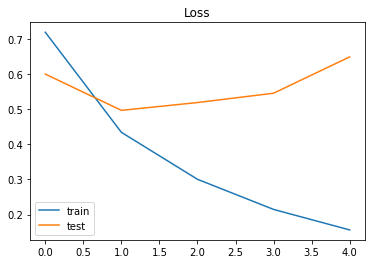

In [13]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

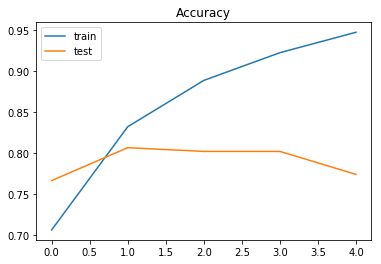

In [14]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

##  <b>Build neural network with CNN <b>
The LSTM model worked well. However, it takes long time to train 3 epochs. One way to speed up the training time is to improve the network adding “Convolutional” layer. Convolutional Neural Networks (CNN) come from image processing. They pass a “filter” over the data and calculate a higher-level representation. They have been shown to work surprisingly well for text, even though they have none of the sequence processing ability of LSTMs.

In [15]:
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(100))
    model_conv.add(Dense(3, activation='softmax'))
    model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_conv 

In [16]:
model_conv = create_conv_model()
history2 = model_conv.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
186/186 [==============================] - 32s 174ms/step - loss: 0.7290 - accuracy: 0.6814 - val_loss: 0.6281 - val_accuracy: 0.7109
Epoch 2/5
186/186 [==============================] - 34s 181ms/step - loss: 0.4384 - accuracy: 0.8298 - val_loss: 0.4948 - val_accuracy: 0.8012
Epoch 3/5
186/186 [==============================] - 34s 184ms/step - loss: 0.2671 - accuracy: 0.9032 - val_loss: 0.5485 - val_accuracy: 0.7914
Epoch 4/5
186/186 [==============================] - 34s 181ms/step - loss: 0.1530 - accuracy: 0.9464 - val_loss: 0.6470 - val_accuracy: 0.7754
Epoch 5/5
186/186 [==============================] - 33s 176ms/step - loss: 0.0896 - accuracy: 0.9713 - val_loss: 0.7792 - val_accuracy: 0.7769


In [17]:
accr2 = model_conv.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr2[0],accr2[1]))

46/46 [==============================] - 1s 16ms/step - loss: 0.8574 - accuracy: 0.7753
Test set
  Loss: 0.857
  Accuracy: 0.775


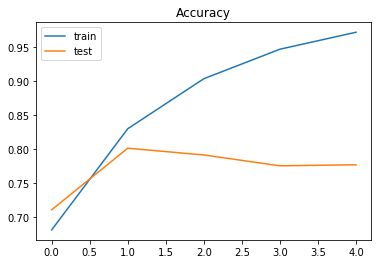

In [18]:
plt.title('Accuracy')
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### Use pre-trained Glove word embeddings
In this subsection, I want to use word embeddings from pre-trained Glove. It was trained on a dataset of one billion tokens (words) with a vocabulary of 400 thousand words. The glove has embedding vector sizes, including 50, 100, 200 and 300 dimensions. I chose the 100-dimensional version. I also want to see the model behavior in case the learned word weights do not get updated. I, therefore, set the trainable attribute for the model to be False.

In [19]:
### Get embeddings from Glove¶

In [98]:
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [99]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((MAX_NB_WORDS, 100))
for word, index in tokenizer.word_index.items():
    if index > MAX_NB_WORDS - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

### Develop model

I use the same model architecture with a convolutional layer on top of the LSTM layer. 

In [100]:
model_glove = Sequential()
model_glove.add(Embedding(MAX_NB_WORDS, 100, input_length=280, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(3, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [101]:
history3 = model_glove.fit(X_train, Y_train, epochs=10, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
186/186 [==============================] - 21s 112ms/step - loss: 0.7209 - accuracy: 0.7010 - val_loss: 0.6206 - val_accuracy: 0.7382
Epoch 2/10
186/186 [==============================] - 21s 115ms/step - loss: 0.6012 - accuracy: 0.7538 - val_loss: 0.5948 - val_accuracy: 0.7504
Epoch 3/10
186/186 [==============================] - 21s 115ms/step - loss: 0.5563 - accuracy: 0.7704 - val_loss: 0.5948 - val_accuracy: 0.7625
Epoch 4/10
186/186 [==============================] - 22s 117ms/step - loss: 0.5157 - accuracy: 0.7880 - val_loss: 0.5766 - val_accuracy: 0.7663
Epoch 5/10
186/186 [==============================] - 22s 120ms/step - loss: 0.4866 - accuracy: 0.8055 - val_loss: 0.5770 - val_accuracy: 0.7633
Epoch 6/10
186/186 [==============================] - 22s 120ms/step - loss: 0.4530 - accuracy: 0.8177 - val_loss: 0.6070 - val_accuracy: 0.7587
Epoch 7/10
186/186 [==============================] - 22s 119ms/step - loss: 0.4201 - accuracy: 0.8315 - val_loss: 0.5892 - val_ac

In [102]:
accr3 = model_glove.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr3[0],accr3[1]))

46/46 [==============================] - 1s 18ms/step - loss: 0.5774 - accuracy: 0.7623
Test set
  Loss: 0.577
  Accuracy: 0.762


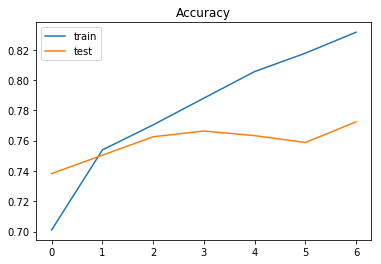

In [103]:
plt.title('Accuracy')
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [22]:
def create_conv_model2():
    model_conv = Sequential()
    model_conv.add(Embedding(MAX_NB_WORDS, 100, input_length=280, weights=[embedding_matrix], trainable=False))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(100))
    model_conv.add(Dense(3, activation='softmax'))
    model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_conv 

In [23]:
model_conv2 = create_conv_model2()
history2 = model_conv2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
186/186 [==============================] - 20s 108ms/step - loss: 0.7428 - accuracy: 0.6897 - val_loss: 0.6760 - val_accuracy: 0.7375
Epoch 2/5
186/186 [==============================] - 20s 106ms/step - loss: 0.6005 - accuracy: 0.7557 - val_loss: 0.6130 - val_accuracy: 0.7496
Epoch 3/5
186/186 [==============================] - 21s 113ms/step - loss: 0.5508 - accuracy: 0.7766 - val_loss: 0.5495 - val_accuracy: 0.7701
Epoch 4/5
186/186 [==============================] - 22s 119ms/step - loss: 0.5214 - accuracy: 0.7885 - val_loss: 0.5602 - val_accuracy: 0.7663
Epoch 5/5
186/186 [==============================] - 21s 114ms/step - loss: 0.4803 - accuracy: 0.8081 - val_loss: 0.5587 - val_accuracy: 0.7701


In [37]:
api=pd.read_csv('tweets_df_12-02.csv')
api['text']

0                       @VirginAmerica What @dhepburn said.
1         @VirginAmerica plus you've added commercials t...
2         @VirginAmerica I didn't today... Must mean I n...
3         @VirginAmerica it's really aggressive to blast...
4         @VirginAmerica and it's a really big bad thing...
                                ...                        
110250    Life’s just better with pie!!! #bakerssquare #...
110251    How much we laughed together anyways @USAirway...
110252    @RealDRothschild let’s start with 25 @Harvard ...
110253    @RobertoRaymon @SouthwestAir @Delta @USAirways...
110254    @Delta @SouthwestAir @SpiritAirlines @American...
Name: text, Length: 110255, dtype: object

In [42]:
len(api['text'])

110255

In [70]:
api['sentiment']=pred['outcome']

In [77]:
api2=api[14640:]

In [79]:
api2.to_csv('labeled_api',index=False)

In [38]:
Xe = tokenizer.texts_to_sequences(api['text'])
Xe = pad_sequences(Xe, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', Xe.shape)

Shape of data tensor: (110255, 280)


In [40]:
predictions=model_conv2.predict(Xe)
classes = np.argmax(predictions, axis = 1)
len(classes)

110255

In [55]:
pd.get_dummies(df['sentiment'])

,negative,neutral,positive
1,0,1,0
2,0,0,1
3,0,1,0
4,1,0,0
5,1,0,0
...,...,...,...
14636,0,0,1
14637,1,0,0
14638,0,1,0
14639,1,0,0


In [57]:
pred= pd.DataFrame(predictions,columns=pd.get_dummies(df['sentiment']).columns)

In [58]:
pred.columns

Index(['negative', 'neutral', 'positive'], dtype='object')

In [60]:
pred['outcome']= 4

In [64]:
for i in range(len(pred['outcome'])):
    if pred['negative'][i]>pred['neutral'][i] and pred['negative'][i]>pred['positive'][i]:
        pred['outcome'][i]='negative'
    elif pred['neutral'][i]>pred['negative'][i] and pred['neutral'][i]>pred['positive'][i]:
        pred['outcome'][i]='neutral'
    else :
        pred['outcome'][i]='positive'

In [69]:
pred[pred['outcome']=='negative']

,negative,neutral,positive,outcome
0,0.491335,0.428272,0.080393,negative
1,0.445904,0.313787,0.240309,negative
3,0.983694,0.006108,0.010198,negative
4,0.727571,0.150116,0.122313,negative
5,0.924439,0.067677,0.007884,negative
...,...,...,...,...
110247,0.522833,0.358697,0.118470,negative
110248,0.913398,0.028268,0.058334,negative
110251,0.570884,0.138197,0.290919,negative
110252,0.832704,0.153486,0.013810,negative


In [50]:
predictions

array([[0.49133536, 0.4282717 , 0.0803929 ],
       [0.44590423, 0.31378704, 0.24030872],
       [0.38984042, 0.5843194 , 0.02584016],
       ...,
       [0.83270377, 0.15348588, 0.01381025],
       [0.18626802, 0.75226724, 0.0614647 ],
       [0.9286269 , 0.05881401, 0.01255911]], dtype=float32)

In [24]:
accr3 = model_conv2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr3[0],accr3[1]))

46/46 [==============================] - 1s 17ms/step - loss: 0.5188 - accuracy: 0.7889
Test set
  Loss: 0.519
  Accuracy: 0.789


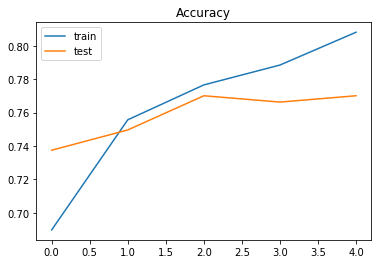

In [25]:
plt.title('Accuracy')
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [110]:
jorge = pd.read_csv('predictions_api_full.csv')

In [108]:
tasos =pd.read_csv('labeled_api.csv')

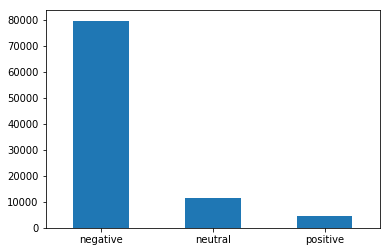

In [130]:
jorge['predicted_sentiment'].value_counts().plot(kind='bar', rot=0)

In [135]:
def clean(combi):
    combi['tidy_text'] = combi['text'].str.replace("[^a-zA-Z#]", " ")
    combi['tidy_text'] = combi['tidy_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [162]:
clean(tasos)

In [159]:
def neg(combi,b):
    negative_words = ' '.join([text for text in combi['tidy_text'][combi[b] == 'negative']])
    h=[x for x in negative_words.split() if x != 'https']
    tokenized_negative_words = nltk.bigrams(h)
    return tokenized_negative_words
def pos(combi,b):
    positive_words = ' '.join([text for text in combi['tidy_text'][combi[b] == 'positive']])
    h=[x for x in positive_words.split() if x != 'https']
    tokenized_positive_words = nltk.bigrams(h)
    return tokenized_positive_words
def neut(combi,b):
    neutral_words = ' '.join([text for text in combi['tidy_text'][combi[b] == 'neutral']])
    h=[x for x in neutral_words.split() if x != 'https']
    tokenized_neutral_words = nltk.bigrams(h)
    return tokenized_neutral_words

In [140]:
import nltk

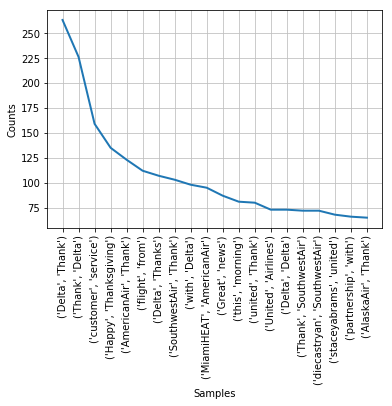

In [164]:
positive_freq = nltk.FreqDist(pos(tasos,'sentiment'))
positive_freq.plot(20, cumulative=False)

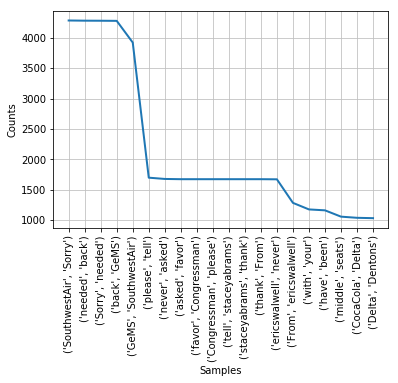

In [166]:
negative_freq = nltk.FreqDist(neg(tasos,'sentiment'))
negative_freq.plot(20, cumulative=False)

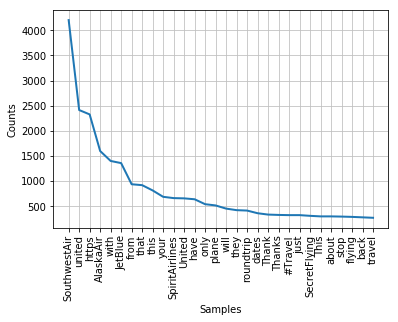

In [148]:
neutral_freq = nltk.FreqDist(neut(jorge,'predicted_sentiment'))
neutral_freq.plot(30, cumulative=False)

In [137]:
tasos['tidy_text']

0        Here reason united wait wear this with uniform...
1        Landed volunteering with TeamRubicon thanks su...
2                            RiverboatRonHC united Amazing
3        Illegal Ballot Harvesting Uncovered https TzAu...
4                     Broncos jsimms astronaut united will
                               ...                        
95610    Life just better with #bakerssquare #crewmembe...
95611    much laughed together anyways USAirways hiring...
95612    RealDRothschild start with Harvard Yale Stanfo...
95613    RobertoRaymon SouthwestAir Delta USAirways Ame...
95614    Delta SouthwestAir SpiritAirlines AmericanAir ...
Name: tidy_text, Length: 95615, dtype: object

In [171]:
tasos['sentiment'].value_counts('negative')

negative    0.640036
neutral     0.265042
positive    0.094922
Name: sentiment, dtype: float64

In [169]:
jorge['predicted_sentiment'].value_counts('negative')

negative    0.833853
neutral     0.120150
positive    0.045997
Name: predicted_sentiment, dtype: float64

In [ ]:
positive_words = ' '.join([text for text in combi['tidy_text'][combi['airline_sentiment'] == 'positive']])